# Representation Learning

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from project_1.loading import *
from project_1.dataset import *
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)

## Define the Encoder and Decoder => Auto Encoder

In [41]:
# Define the encoder model using an LSTM with dropout.
class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_dim, dropout=0.3):
        super(TimeSeriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        # Project the last hidden state to a lower-dimensional embedding space.
        self.fc = nn.Linear(hidden_size, embedding_dim)
    
    def forward(self, x):
        # x: [batch, seq_len, input_size]
        _, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]  # Shape: [batch, hidden_size]
        h_last = self.dropout(h_last)
        embedding = self.fc(h_last)  # Shape: [batch, embedding_dim]
        return embedding
    
# Define the decoder model that reconstructs the time series from the embedding.
class TimeSeriesDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers, output_size, seq_len, dropout=0.3):
        super(TimeSeriesDecoder, self).__init__()
        self.seq_len = seq_len
        self.fc = nn.Linear(embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, embedding):
        # embedding: [batch, embedding_dim]
        # Map the embedding to the hidden state dimension.
        hidden = self.fc(embedding)  # Shape: [batch, hidden_size]
        hidden = self.dropout(hidden)
        # Repeat the hidden state seq_len times to create a sequence input.
        repeated = hidden.unsqueeze(1).repeat(1, self.seq_len, 1)  # Shape: [batch, seq_len, hidden_size]
        lstm_out, _ = self.lstm(repeated)
        lstm_out = self.dropout(lstm_out)
        # Reconstruct the input features at each time step.
        output = self.out(lstm_out)  # Shape: [batch, seq_len, output_size]
        return output

# Combine encoder and decoder into an autoencoder.
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_dim, seq_len, dropout=0.3):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encoder = TimeSeriesEncoder(input_size, hidden_size, num_layers, embedding_dim, dropout)
        self.decoder = TimeSeriesDecoder(embedding_dim, hidden_size, num_layers, input_size, seq_len, dropout)
    
    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction


In [42]:
def pretrain_autoencoder(autoencoder, train_loader, val_loader, num_epochs=20, learning_rate=1e-3, device='cpu'):
    autoencoder.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training Phase
        autoencoder.train()
        total_train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()
            reconstruction = autoencoder(inputs)
            loss = criterion(reconstruction, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        
        # Validation Phase
        autoencoder.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                reconstruction = autoencoder(inputs)
                loss = criterion(reconstruction, inputs)
                total_val_loss += loss.item() * inputs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        
    return autoencoder

## Load the data and prepare the DataLoaders

In [43]:
set_a, set_b, set_c = load_final_data_without_ICU()
death_a, death_b, death_c = load_outcomes()

Shapes of the datasets:
Set A: (183416, 42) Set B: (183495, 42) Set C: (183711, 42)
Shapes of labels:
Set A: (4000, 2) Set B: (4000, 2) Set C: (4000, 2)


In [44]:
train_dataset = create_dataset_from_timeseries(set_a, death_a["In-hospital_death"])
validation_dataset = create_dataset_from_timeseries(set_b, death_b["In-hospital_death"])
test_dataset = create_dataset_from_timeseries(set_c, death_c["In-hospital_death"])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataset.tensors[0].shape

torch.Size([4000, 49, 40])

# Start Process

In [45]:
# Define the hyperparameters
hidden_size = 64
input_size = train_dataset.tensors[0].shape[2] # The features
num_layers = 2
embedding_dim = 128
seq_len = train_dataset.tensors[0].shape[1] # The sequence length

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = TimeSeriesAutoencoder(input_size, hidden_size, num_layers, embedding_dim, seq_len)
pretrained_autoencoder = pretrain_autoencoder(autoencoder, train_loader, validation_loader, num_epochs=20, device=device)

# Extract the pretrained encoder for downstream tasks (e.g., linear probing).
pretrained_encoder = pretrained_autoencoder.encoder
print("Pretraining complete. The encoder is ready for use in a linear probe.")

Epoch 1/20 - Train Loss: 27.2386 - Val Loss: 15.2243
Epoch 2/20 - Train Loss: 26.7282 - Val Loss: 14.9157
Epoch 3/20 - Train Loss: 26.0179 - Val Loss: 14.7258
Epoch 4/20 - Train Loss: 25.3888 - Val Loss: 14.5969
Epoch 5/20 - Train Loss: 24.9592 - Val Loss: 14.4859
Epoch 6/20 - Train Loss: 24.5784 - Val Loss: 14.3582
Epoch 7/20 - Train Loss: 24.2341 - Val Loss: 14.2833
Epoch 8/20 - Train Loss: 23.9384 - Val Loss: 14.1763
Epoch 9/20 - Train Loss: 23.7102 - Val Loss: 14.0976
Epoch 10/20 - Train Loss: 23.5119 - Val Loss: 14.1223
Epoch 11/20 - Train Loss: 23.2944 - Val Loss: 14.0453
Epoch 12/20 - Train Loss: 23.1642 - Val Loss: 13.8992
Epoch 13/20 - Train Loss: 22.9093 - Val Loss: 13.9257
Epoch 14/20 - Train Loss: 22.6970 - Val Loss: 13.8783
Epoch 15/20 - Train Loss: 22.4686 - Val Loss: 13.7791
Epoch 16/20 - Train Loss: 22.3379 - Val Loss: 13.7797
Epoch 17/20 - Train Loss: 22.1654 - Val Loss: 13.7614
Epoch 18/20 - Train Loss: 21.9769 - Val Loss: 13.7327
Epoch 19/20 - Train Loss: 22.0461 - V

# Q3.1.2

In [46]:
# Freeze the encoder weights
pretrained_encoder.eval()
for param in pretrained_encoder.parameters():
    param.requires_grad = False

def extract_embeddings(encoder, dataloader, device):
    """
    Compute embeddings for all samples in the dataloader using the provided encoder.
    
    Returns:
        embeddings: numpy array of shape [num_samples, embedding_dim]
        targets: numpy array of shape [num_samples]
    """
    encoder.eval()
    embeddings_list = []
    targets_list = []
    with torch.no_grad():
        for batch in dataloader:
            # Assuming each batch is a tuple (data, target)
            inputs, targets = batch[0].to(device), batch[1]
            embeddings = encoder(inputs)  # compute embeddings
            embeddings_list.append(embeddings.cpu().numpy())
            targets_list.append(targets.numpy())
    embeddings_all = np.concatenate(embeddings_list, axis=0)
    targets_all = np.concatenate(targets_list, axis=0)
    return embeddings_all, targets_all

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Extract embeddings for train, validation, and test sets.
train_embeddings, train_targets = extract_embeddings(pretrained_encoder, train_loader, device)
val_embeddings, val_targets = extract_embeddings(pretrained_encoder, validation_loader, device)
test_embeddings, test_targets = extract_embeddings(pretrained_encoder, test_loader, device)

# Train a logistic regression classifier on the training embeddings.
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, train_targets)

# Evaluate on validation and test sets.
val_probs = clf.predict_proba(val_embeddings)[:, 1]
test_probs = clf.predict_proba(test_embeddings)[:, 1]

val_preds = clf.predict(val_embeddings)
test_preds = clf.predict(test_embeddings)

val_acc = accuracy_score(val_targets, val_preds)
test_acc = accuracy_score(test_targets, test_preds)

val_roc_auc = roc_auc_score(val_targets, val_probs)
test_roc_auc = roc_auc_score(test_targets, test_probs)

val_apr = average_precision_score(val_targets, val_probs)
test_apr = average_precision_score(test_targets, test_probs)

#print("Validation Accuracy: {:.4f}".format(val_acc))
print("Validation ROC AUC: {:.4f}".format(val_roc_auc))
print("Validation Average Precision: {:.4f}".format(val_apr))
#print("Test Accuracy: {:.4f}".format(test_acc))
print("Test ROC AUC: {:.4f}".format(test_roc_auc))
print("Test Average Precision: {:.4f}".format(test_apr))

Validation ROC AUC: 0.6401
Validation Average Precision: 0.2723
Test ROC AUC: 0.6007
Test Average Precision: 0.2283


# Q3.3 - VISUALIZATION OF EMBEDDINGS

## TSNE7

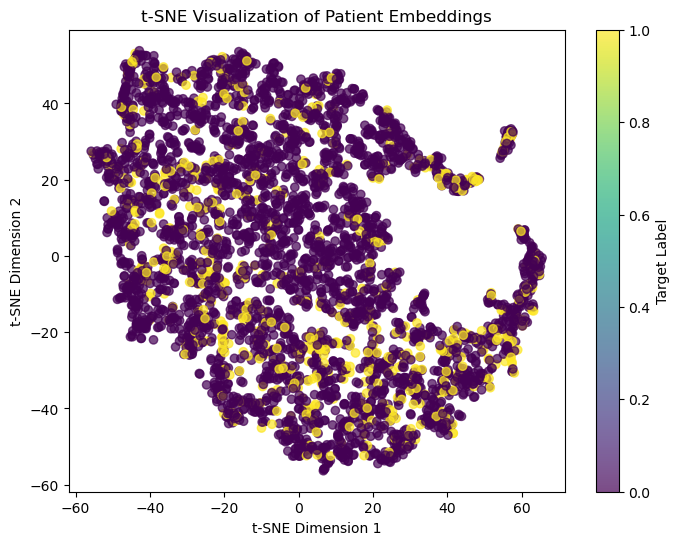

Silhouette Score: 0.019802818


In [48]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

embeddings, labels = extract_embeddings(pretrained_encoder, test_loader, device)

# Perform t-SNE dimensionality reduction to 2D.
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize the 2D embeddings.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Label')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Compute a quantitative clustering metric (Silhouette Score) using the target labels.
score = silhouette_score(embeddings_2d, labels)
print("Silhouette Score:", score)


## UMAP8 (requires the package umap-learn)

/Users/francescobondi/anaconda3/envs/TUM/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


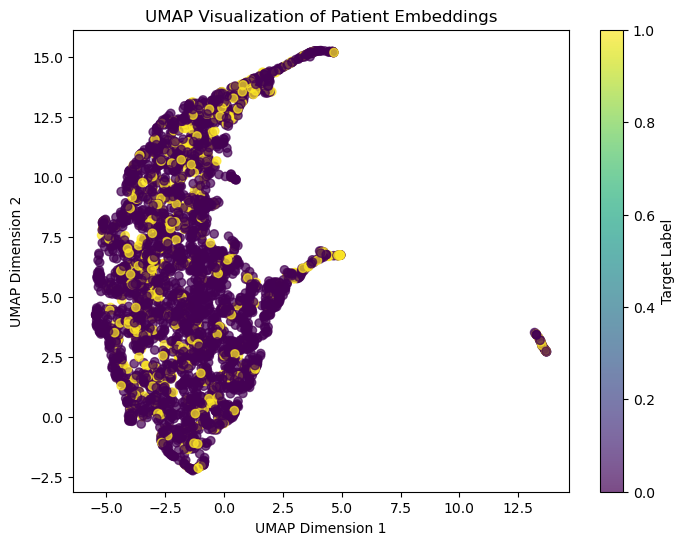

Silhouette Score: 0.046612937


In [49]:
import umap
# Initialize UMAP with some typical hyperparameters.
# You may tune n_neighbors, min_dist, etc. for best results.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the embeddings into 2D.
embeddings_2d = reducer.fit_transform(embeddings)

# Plot the 2D embeddings, colored by label.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Label')
plt.title("UMAP Visualization of Patient Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# (Optional) Compute a clustering metric, e.g., silhouette score.
score = silhouette_score(embeddings_2d, labels)
print("Silhouette Score:", score)
